In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Models
from bella.models.target import TargetInd
from bella.models.target import TargetDepC
from bella.models.target import TargetDep
from bella.models.target import TargetDepSent
# Word Vector methods
from bella.word_vectors import VoVectors, SSWE
from bella.helper import read_config
# Sentiment lexicons
from bella import lexicons
# Get the data
from bella.parsers import dong, semeval_14
# Tokenisers
from bella.tokenisers import ark_twokenize, stanford

Using TensorFlow backend.


# Target dependent models
This notebook shows how to use the target dependent models and comparing the results of our implementation to the one in the original [paper](https://www.ijcai.org/Proceedings/15/Papers/194.pdf). We also show the problems we encountered when attempting to reproduce the methods from the description in the paper and the affects of not stating certain processes.

The paper had four different models:
1. **Target-Ind** -- Uses only the full Tweet as context.
2. **Target-Dep-** -- Uses the left and right context of the target word as well as the target word as context.
3. **Target-Dep** -- Uses all of the above contexts.
4. **Target-Dep+** -- Uses all of the above as well as including two additional left and right contexts which ignores all words in the contexts unless they are part of the given sentiment lexicon (or any lexicon).

The above models correspond to the following classes in our implementation:
1. [TargetInd](../tdparse/models/target.py), 2. [TargetDepC](../tdparse/models/target.py), 3. [TargetDep](../tdparse/models/target.py), 4. [TargetDepSent](../tdparse/models/target.py)

All of the results shown below are 5 fold cross validation over the training data of [Dong et al.](https://aclanthology.coli.uni-saarland.de/papers/P14-2009/p14-2009) or where appropriate on the test data as reported in the paper.

In [2]:
##
#  ADD YOUR CONFIG FILE PATH HERE 
##
CONFIG_FP = Path('..', 'config.yaml')

# Load the training data
dong_train = dong(read_config('dong_twit_train_data', CONFIG_FP))
dong_test = dong(read_config('dong_twit_test_data', CONFIG_FP))
train_data = dong_train.data()
test_data = dong_test.data()
train_y = dong_train.sentiment_data()
test_y = dong_test.sentiment_data()

# Get word vectors
# To reduce the number of vectors we load we only load
# the words that are within the train and test set
# which is still as fair in practice as loading the whole
# word vectors
train_words = dong_train.word_list(ark_twokenize)
test_words = dong_test.word_list(ark_twokenize)
all_words = list(set(train_words + test_words))
w2v = VoVectors(filter_words=all_words)
sswe = SSWE(filter_words=all_words)

# Comparing the three base models

In the paper the base models (target-ind, target-dep- and target-dep) using the the word2vec word vectors were compared after they found the best C-values therefore we are going to use the C-Values stated in the paper to compare our results to theres. **random_state** is used here to ensure that the results are reproducible, it stops the data from randomly shuffling.

In [3]:
# Instances of the models
target_ind = TargetInd()
target_depc = TargetDepC()
target_dep = TargetDep()
# Getting the grid parameters for each model
grid_params_ind = target_ind.get_cv_params(word_vectors=[[w2v]], random_state=42)
grid_params_depc = target_depc.get_cv_params(word_vectors=[[w2v]], random_state=42)
grid_params_dep = target_dep.get_cv_params(word_vectors=[[w2v]], random_state=42)
# Running the grid search over 5 folds.
results_ind = target_ind.grid_search(train_data, train_y, params=grid_params_ind, cv=5, n_jobs=5)
results_depc = target_depc.grid_search(train_data, train_y, params=grid_params_depc, cv=5, n_jobs=5)
results_dep = target_dep.grid_search(train_data, train_y, params=grid_params_dep, cv=5, n_jobs=5)

In [4]:
results = [results_ind['mean_test_score'], results_depc['mean_test_score'], results_dep['mean_test_score']]
all_results = {'Our results' : [result.round(4)[0] * 100 for result in results]}
all_results['Paper results'] = [59.22, 65.38, 65.72]
index = ['Target-Ind', 'Target-Dep-', 'Target-Dep']
base_model_df = pd.DataFrame(all_results, index=index)
base_model_df

,Our results,Paper results
Target-Ind,60.98,59.22
Target-Dep-,65.67,65.38
Target-Dep,66.81,65.72


As you can see from the results above that we get similar results and the order of the models stays the same.

# Target-Dep+ and sentiment lexicons
The **Target-Dep+** model uses sentiment lexicons to remove words therefore in this section we compare:
1. The statistics on the sentiment lexicons
2. The results of the model using different lexicons

All the experiments below again use the Word2Vec word embeddings.
## Sentiment lexicon statistics

Below we present the size of the sentiment lexicon once it has been processed and the size of that lexicon stated in the paper.

In [5]:
# Load the sentiment lexicons and remove all words that are not associated
# to the Positive or Negative class.

lexicon_data = read_config('lexicons', CONFIG_FP)
hu_liu_fp = Path(lexicon_data['hu_liu'])
mpqa_fp = Path(lexicon_data['mpqa'])
nrc_fp = Path(lexicon_data['nrc_emotion'])

subset_cats = {'positive', 'negative'}
mpqa = lexicons.Mpqa(mpqa_fp, subset_cats=subset_cats)
nrc = lexicons.NRC(nrc_fp, subset_cats=subset_cats)
hu_liu = lexicons.HuLiu(hu_liu_fp, subset_cats=subset_cats)
# Combine sentiment lexicons - Removes words that contradict each other.
mpqa_huliu = lexicons.Lexicon.combine_lexicons(mpqa, hu_liu)
all_three = lexicons.Lexicon.combine_lexicons(mpqa_huliu, nrc)

# Load the sentiment lexicons but lower case all the words
mpqa_low = lexicons.Mpqa(mpqa_fp, subset_cats=subset_cats, lower=True)
nrc_low = lexicons.NRC(nrc_fp, subset_cats=subset_cats, lower=True)
hu_liu_low = lexicons.HuLiu(hu_liu_fp, subset_cats=subset_cats, lower=True)
mpqa_huliu_low = lexicons.Lexicon.combine_lexicons(mpqa_low, hu_liu_low)
all_three_low = lexicons.Lexicon.combine_lexicons(mpqa_huliu_low, nrc_low)

In [6]:
def filter_cat(lexicon, filter_cat):
    return [word for word, cat in lexicon.lexicon if cat == filter_cat]

all_lexicons = [mpqa, hu_liu, nrc, mpqa_huliu, all_three]
num_positive = [len(filter_cat(lexicon, 'positive')) for lexicon in all_lexicons]
num_negative = [len(filter_cat(lexicon, 'negative')) for lexicon in all_lexicons]

all_lexicons_low = [mpqa_low, hu_liu_low, nrc_low, mpqa_huliu_low, all_three_low]
num_positive_low = [len(filter_cat(lexicon, 'positive')) for lexicon in all_lexicons_low]
num_negative_low = [len(filter_cat(lexicon, 'negative')) for lexicon in all_lexicons_low]

columns = ['Paper No. Positive', 'Ours No. Positive', 'Ours low No. Positive', 
           'Paper No. Negative', 'Ours No. Negative', 'Ours low No. Negative']
index = ['MPQA', 'Hu Liu', 'NRC', 'MPQA & Hu Liu', 'All Three']
data = [[2289, 2003, 2231, 2706, 3940], num_positive, num_positive_low, 
        [4114, 4780, 3243, 5069, 6490], num_negative, num_negative_low]
senti_info = dict(list(zip(columns, data)))
pd.DataFrame(senti_info, columns=columns, index=index)

,Paper No. Positive,Ours No. Positive,Ours low No. Positive,Paper No. Negative,Ours No. Negative,Ours low No. Negative
MPQA,2289,2298,2298,4114,4148,4148
Hu Liu,2003,2003,2003,4780,4780,4780
NRC,2231,2231,2231,3243,3243,3243
MPQA & Hu Liu,2706,2725,2725,5069,5080,5076
All Three,3940,4016,4016,6490,6530,6526


In [7]:
# Words that are shared between the MPQA and Hu Liu sentiment lexicons
[word for word, cat in list(set(mpqa_huliu.lexicon).difference(set(mpqa_huliu_low.lexicon))) if cat == 'negative']

['anti-Israeli', 'anti-Semites', 'anti-American', 'anti-US']

As you can see we never agree on the number of words within the lexicons. We get the lexicons from the sources described in the paper. Intrestingly if we do not lower case the words in the lexicons we won't see the same similarities between the MPQA and Hu Liu sentiment lexicon as they both share the words above just the Hu Liu lexicon has the words lower cased already where as MPQA has not.

## Showing the affect of using different sentiment lexicons in the Target-Dep+ model

In [8]:
# Instances of the model
target_dep_plus = TargetDepSent()
# Getting the grid parameters for each model
grid_params_sent = target_dep_plus.get_cv_params(word_vectors=[[w2v]], senti_lexicons=all_lexicons_low,
                                                 random_state=42)
# Running the grid search over 5 folds.
results_sent = target_dep_plus.grid_search(train_data, train_y, params=grid_params_sent, cv=5, n_jobs=5)

In [9]:
all_sent_results = {'Paper results' : [65.72, 66.05, 67.24, 65.56, 67.40, 67.30],
                    'Our results' : np.zeros(6)}
index = ['Target-Dep', 'Target-Dep+: NRC', 'Target-Dep+: Hu Liu', 'Target-Dep+: MPQA',
         'Target-Dep+: MPQA + Hu Liu', 'Target-Dep+: All Three']
sent_results_df = pd.DataFrame(all_sent_results, index=index)
sent_results_df['Our results']['Target-Dep'] = base_model_df['Our results']['Target-Dep']

In [10]:
name_map = {'Mpqa' : 'Target-Dep+: MPQA', 'HuLiu' : 'Target-Dep+: Hu Liu', 'NRC' : 'Target-Dep+: NRC',
            'Mpqa HuLiu' : 'Target-Dep+: MPQA + Hu Liu', 'Mpqa HuLiu NRC' : 'Target-Dep+: All Three'}
results_sent['lexicon'] = results_sent['param_union__left_s__filter__lexicon'].apply(lambda lex: lex.name)
for lex_name, model_name in name_map.items():
    score = results_sent.loc[results_sent['lexicon'] == lex_name]['mean_test_score']
    score = score.round(4) * 100
    sent_results_df['Our results'][model_name] = score
sent_results_df['Our results']['Target-Dep'] = base_model_df['Our results']['Target-Dep']
sent_results_df

,Our results,Paper results
Target-Dep,66.81,65.72
Target-Dep+: NRC,67.13,66.05
Target-Dep+: Hu Liu,68.61,67.24
Target-Dep+: MPQA,66.81,65.56
Target-Dep+: MPQA + Hu Liu,68.37,67.40
Target-Dep+: All Three,68.23,67.30


From the results shown above we get different results but the results also have a different rank between the lexicons as in the best lexicon was **Hu and Liu** where as the papers original results show the combination of **MPQA and Hu & Liu** was the best. However in general we can see that it is better to use a sentiment lexicon than not. Also that both our implmentation and the original paper show that the best single sentiment lexicon is **Hu & Liu** and that using **all three** sentiment lexicons is worse than using **MPQA and Hu & Liu**.

# Showing the affect of the different word vectors
As presented in the paper they show the affect of using different word vectors accross the four models using the best sentiment lexicon for the sentiment dependent model. As we had different result for the sentiment lexicons compared to the original paper we will show the results of using **Hu & Liu** lexicon and using the combination of **Hu & Liu and MPQA**. The word vectors used are the following:
1. Word2Vec - Which has been used throughout the previous experiments (100 dimensions)
2. SSWE - Sentiment Specific Word Embeddings (50 dimensions)
3. Concatenation of Word2vec and SSWE (150 dimensions)

In [11]:
# Process the results
grid_params_ind = target_ind.get_cv_params(word_vectors=[[w2v], [sswe], [w2v, sswe]], random_state=42)
grid_params_depc = target_depc.get_cv_params(word_vectors=[[w2v], [sswe], [w2v, sswe]], random_state=42)
grid_params_dep = target_dep.get_cv_params(word_vectors=[[w2v], [sswe], [w2v, sswe]], random_state=42)
grid_params_dep_sent = target_dep_plus.get_cv_params(word_vectors=[[w2v], [sswe], [w2v, sswe]], 
                                                     senti_lexicons=[hu_liu_low, mpqa_huliu_low], random_state=42)

results_ind = target_ind.grid_search(train_data, train_y, params=grid_params_ind, cv=5, n_jobs=5)
results_depc = target_depc.grid_search(train_data, train_y, params=grid_params_depc, cv=5, n_jobs=5)
results_dep = target_dep.grid_search(train_data, train_y, params=grid_params_dep, cv=5, n_jobs=5)
results_dep_sent = target_dep_plus.grid_search(train_data, train_y, params=grid_params_dep_sent, cv=5, n_jobs=5)

In [12]:
# Wrangling the results
results_dep_sent['lexicon'] = results_dep_sent['param_union__left_s__filter__lexicon'].apply(lambda lex: lex.name)
results_dep_sent_hu = results_dep_sent[results_dep_sent['lexicon'] == 'HuLiu']
results_dep_sent_hu_mpqa = results_dep_sent[results_dep_sent['lexicon'] == 'Mpqa HuLiu']
grid_results = {'Target-Ind' : results_ind, 'Target-Dep-' : results_depc, 'Target-Dep' : results_dep, 
                'Target-Dep+: Hu Liu' : results_dep_sent_hu, 
                'Target-Dep+: MPQA + Hu Liu' : results_dep_sent_hu_mpqa}
index = ['word2vec', 'sswe', 'word2vec + sswe']
columns = list(grid_results.keys())
name_map = {'w2v' : 'word2vec', 'sswe' : 'sswe', 'w2vsswe' : 'word2vec + sswe'}
vector_results_df = pd.DataFrame(np.zeros((len(index), len(columns))), columns=columns, index=index)
for model_name, result in grid_results.items():
    vec_col = result.columns[result.columns.map(lambda x: 'vector' in x)==True][0]
    get_vec_name = lambda vec_list: ''.join(map(lambda vec: vec.name, vec_list))
    result['vector'] = result[vec_col].apply(get_vec_name)
    for vec_name, index_name in name_map.items():
        score = result.loc[result['vector'] == vec_name]['mean_test_score']
        score = score.round(4) * 100
        vector_results_df[model_name][index_name] = score
vector_results_df


,Target-Ind,Target-Dep-,Target-Dep,Target-Dep+: Hu Liu,Target-Dep+: MPQA + Hu Liu
word2vec,60.98,65.67,66.81,68.61,68.37
sswe,60.18,66.74,66.37,68.01,67.72
word2vec + sswe,63.20,67.46,68.02,69.41,69.05


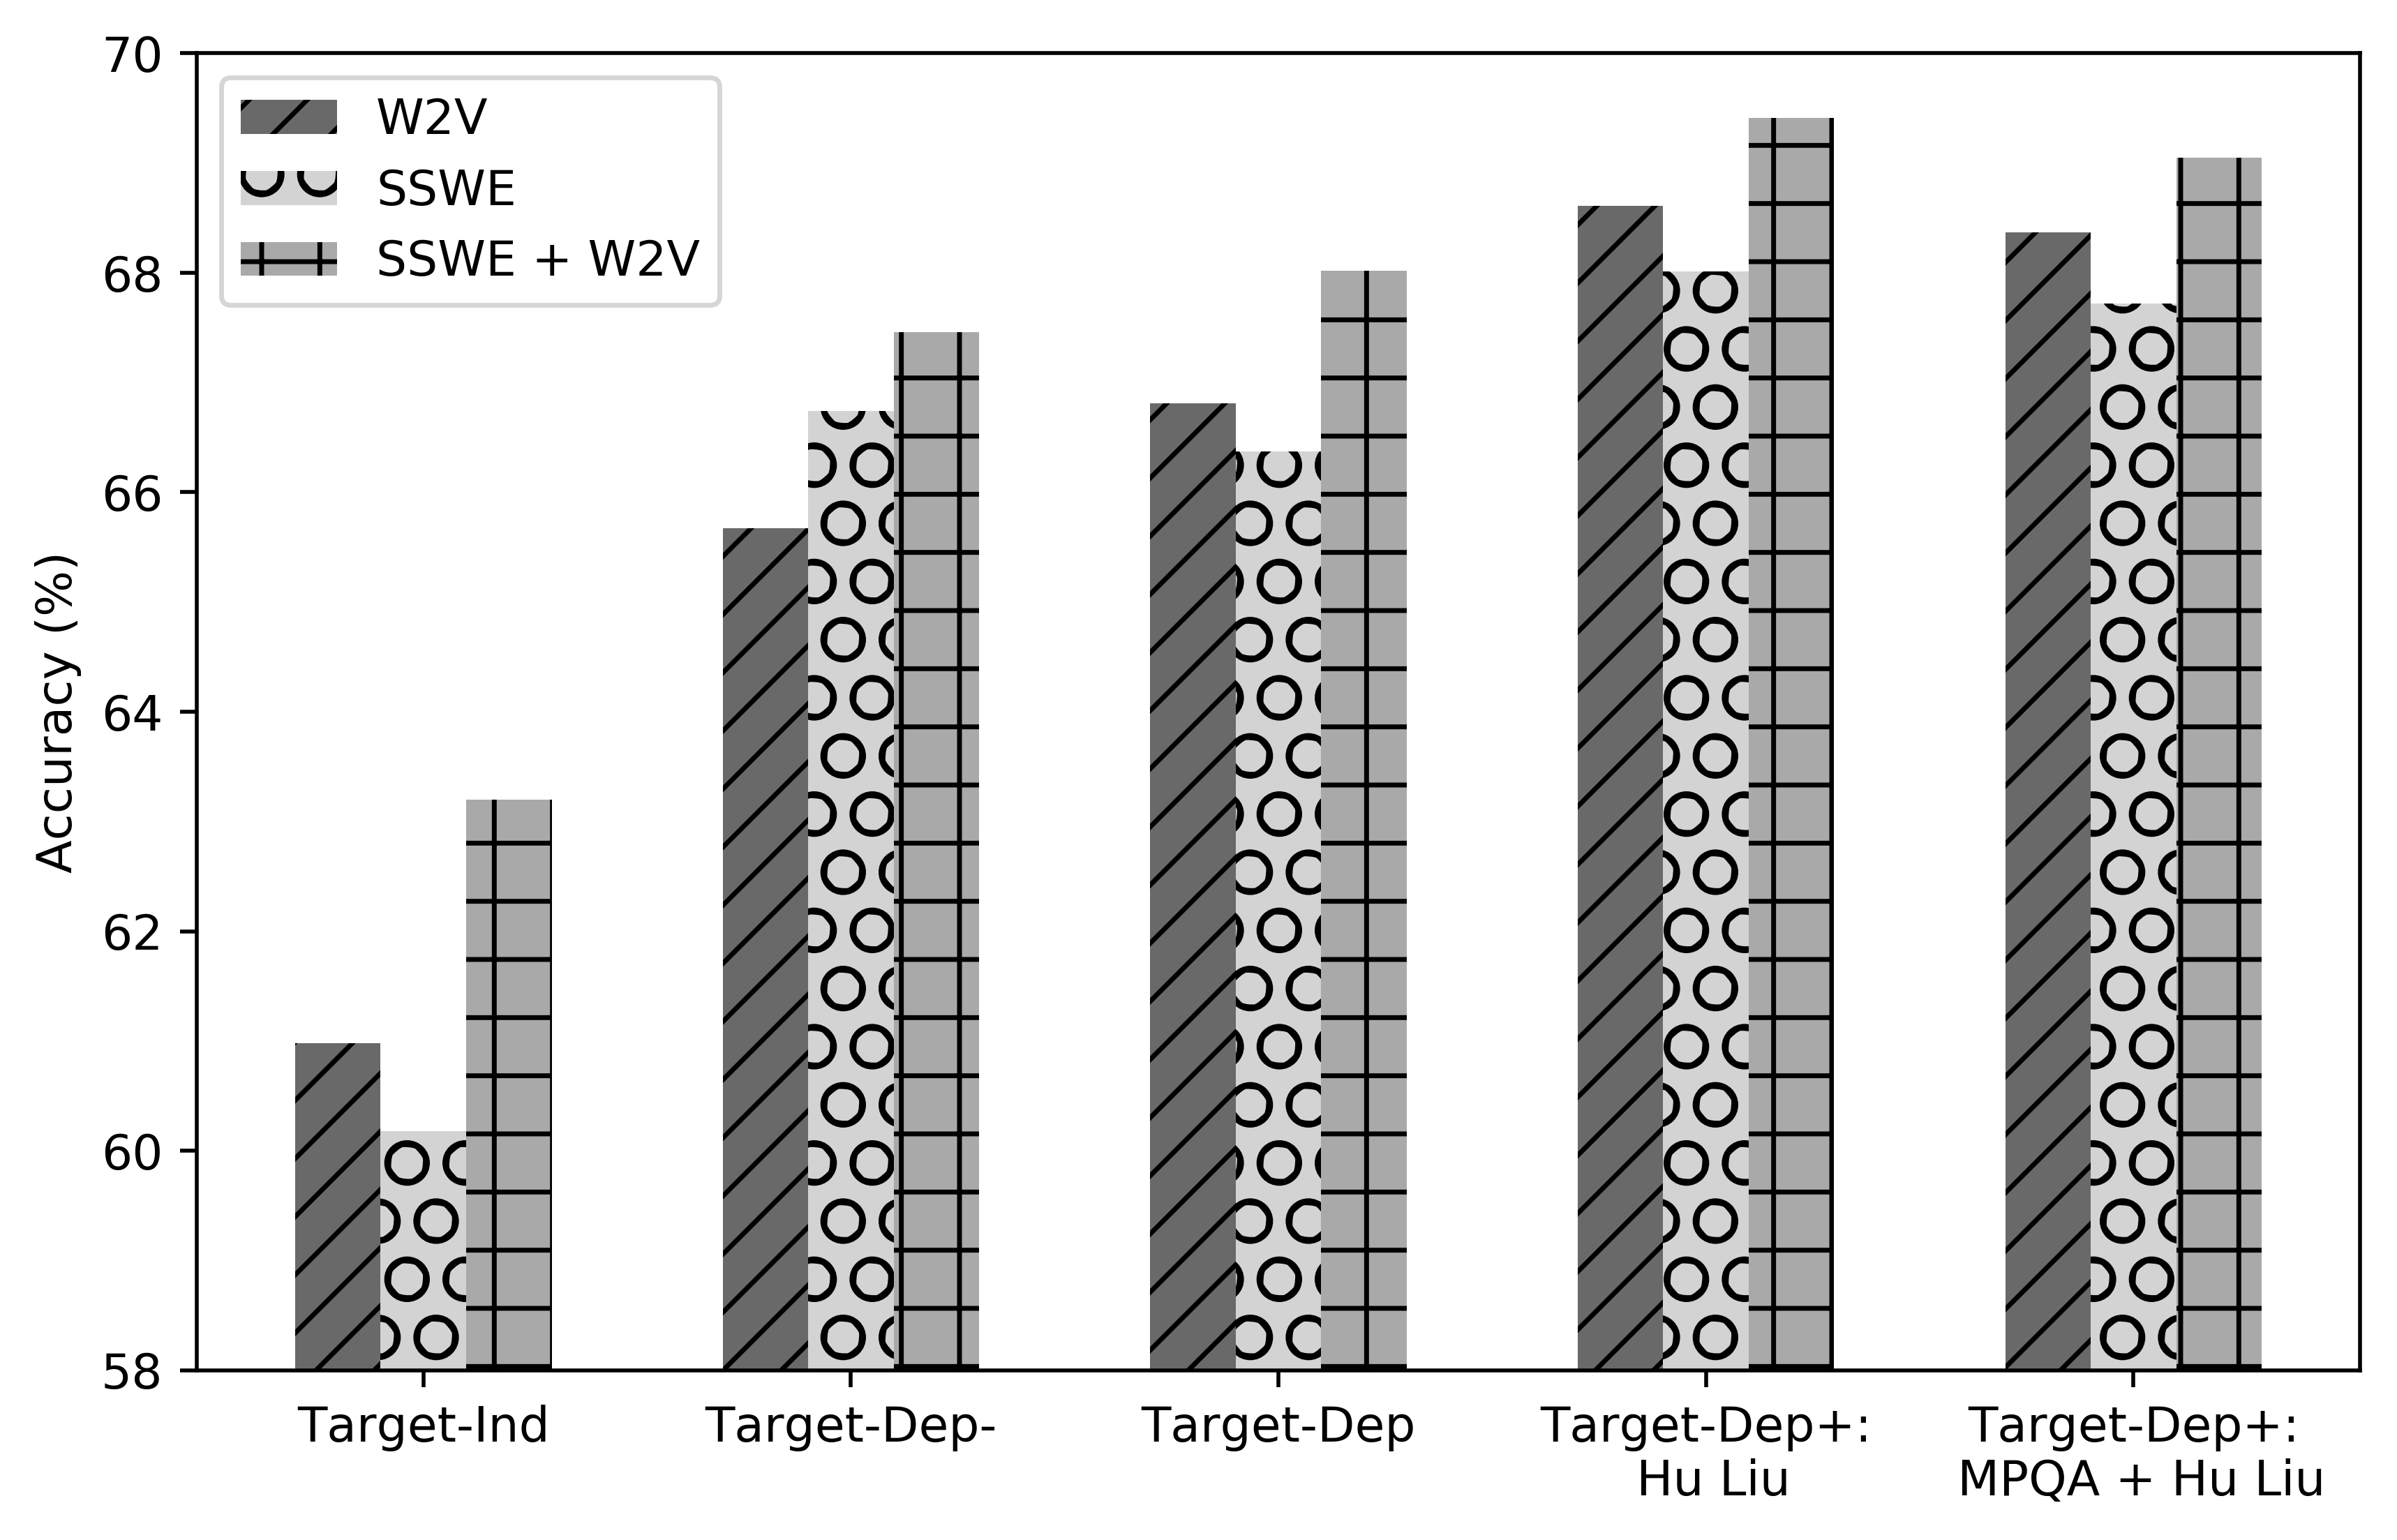

In [21]:
# Below we show how to visualise the table above as they did in the original paper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

model_index = {index : model for index, model in enumerate(grid_results.keys())}
num_models = len(model_index)

word2vec_values = [vector_results_df[model_index[index]]['word2vec']\
                   for index in range(num_models)]
sswe_values = [vector_results_df[model_index[index]]['sswe']\
               for index in range(num_models)]
word_sswe_values = [vector_results_df[model_index[index]]['word2vec + sswe']\
                    for index in range(num_models)]
ind = np.arange(num_models)
width = 0.2
fig, ax = plt.subplots(dpi=500)
fig.set_size_inches(8,5)
word2vec_bar = ax.bar(ind, word2vec_values, width, color='dimgrey', hatch='//')
sswe_bar = ax.bar(ind + width, sswe_values, width, color='lightgray', hatch='O')
word_sswe_bar = ax.bar(ind + (2 * width), word_sswe_values, width, 
                       color='darkgray', hatch='+')


ax.set_xticks(ind + width)
ax.set_ylim([58 ,70])
model_names = [model_index[index] for index in range(num_models)]
model_names[3] = 'Target-Dep+:\n Hu Liu'
model_names[4] = 'Target-Dep+:\n MPQA + Hu Liu'
ax.set_xticklabels(model_names)
ax.legend((word2vec_bar, sswe_bar, word_sswe_bar), ('W2V', 'SSWE', 'SSWE + W2V'))

ax.set_ylabel('Accuracy (%)')
fig.savefig('Effectiveness of word embedding.png', dpi=300)

As we can see from the results above using the combination of the two word vectors is best accross all models which is the finding in the original paper. Also that **Target-Dep+** > **Target-Dep** > **Target-Dep-** > **Target-Ind** which is also what the original paper found. However un-like the original paper we found that using the *SSWE* word vectors to be generally worse than using the *Word2Vec* vectors showing that using just semantic information is more important than using a vector model that was created by reducing the semantic and sentiment loss. Also we found that using **Hu & Liu** lexicon to be better than any other and any other combination of lexicons compared to the original paper which found using the combination of **MPQA and Hu & Liu** to be the best. Finally we can see that we got similar results to the original.

# Results of the final models on the test data
Here we show the affect of the **Target-Ind**, **Target-Dep**, and **Target-Dep+** models on the test data as reported in the paper where each model uses the best parameters found in the previous tests.

For the **Target-Dep+** we show using **Hu & Liu** lexicon and using the combination of **MPQA and Hu & Liu** for direct comparison with the original paper as they found using **MPQA and Hu & Liu** to be better than **Hu & Liu** however we did not.

In [14]:
target_dep_plus_mpqa = TargetDepSent()

best_params_ind = target_ind.get_params(word_vector=[w2v, sswe], random_state=42)
best_params_dep = target_dep.get_params(word_vector=[w2v, sswe], random_state=42)
best_params_dep_sent_hu = target_dep_plus.get_params(word_vector=[w2v, sswe], senti_lexicon=hu_liu_low,
                                                     random_state=42)
best_params_dep_sent_mpqa = target_dep_plus_mpqa.get_params(word_vector=[w2v, sswe], senti_lexicon=mpqa_huliu_low,
                                                       random_state=42)

target_ind.fit(train_data, train_y, params=best_params_ind)
target_dep.fit(train_data, train_y, params=best_params_dep)
target_dep_plus.fit(train_data, train_y, params=best_params_dep_sent_hu)
target_dep_plus_mpqa.fit(train_data, train_y, params=best_params_dep_sent_mpqa)

In [15]:
target_ind_res = target_ind.predict(test_data)
target_dep_res = target_dep.predict(test_data)
target_dep_plus_res_hu = target_dep_plus.predict(test_data)
target_dep_plus_res_mpqa = target_dep_plus_mpqa.predict(test_data)

results = [target_ind_res, target_dep_res, target_dep_plus_res_mpqa, target_dep_plus_res_hu]
scorers = {'acc' : accuracy_score, 'F1' : f1_score}
final_results_dict = {'Our results (Acc)' : [], 'Our results (Macro F1)' : []}
for result in results:
    for scorer_name, scorer in scorers.items():
        if scorer_name == 'F1':
            score = round(scorer(test_y, result, average='macro') * 100, 1)
            final_results_dict['Our results (Macro F1)'].append(score)
        else:
            score = round(scorer(test_y, result) * 100, 1)
            final_results_dict['Our results (Acc)'].append(score)

In [16]:
index = ['Target-Ind', 'Target-Dep', 'Target-Dep+ (MPQA & Hu Liu)', 'Target-Dep+ (Hu Liu)']
final_results_dict['Paper results (Acc)'] = [67.3, 69.7, 71.1, 0.]
final_results_dict['Paper results (Macro F1)'] = [66.4, 68.0, 69.9, 0.]
final_results_df = pd.DataFrame(final_results_dict, index=index)
final_results_df[['Our results (Acc)', 'Paper results (Acc)', 
                  'Our results (Macro F1)', 'Paper results (Macro F1)']]

,Our results (Acc),Paper results (Acc),Our results (Macro F1),Paper results (Macro F1)
Target-Ind,66.0,67.3,61.9,66.4
Target-Dep,69.7,69.7,66.7,68.0
Target-Dep+ (MPQA & Hu Liu),69.9,71.1,67.6,69.9
Target-Dep+ (Hu Liu),70.8,0.0,68.7,0.0


As you can see from above our results are very close to those reported in the paper and are identical for **Target-Dep** model. Also as you can see that our results using the **Hu Liu** lexicon are much better and are closer to the results of **Target-Dep+** in the original paper 

# Fine Tuning
We want to see if instead of using the C-Value reported in the paper, we fine tune our-seleves the C-Value where we use the combination of **Word2Vec** and **SSWE** embeddings which was never done/shown in the paper to see if we get values closer to those reported in the paper. We only do this for the best model (**Target-Dep+ (Hu Liu)**)


In [45]:
c_grid_params = {'word_vectors' : [[w2v, sswe]], 'random_state' : 42, 'senti_lexicons' : [hu_liu_low]}
best_c, _ = target_dep_plus.find_best_c(train_data, train_y, grid_params=c_grid_params, cv=5, n_jobs=5)
best_params = target_dep_plus.get_params(word_vector=[w2v, sswe], senti_lexicon=hu_liu_low,
                                         random_state=42, C=best_c)
target_dep_plus.fit(train_data, train_y, params=best_params)

In [46]:
target_dep_plus_res = target_dep_plus.predict(test_data)
norm_score = lambda score: round(score * 100, 1)
score_acc = norm_score(accuracy_score(test_y, target_dep_plus_res))
score_f1 = norm_score(f1_score(test_y, target_dep_plus_res, average='macro') )

index = ['Our results (Acc)', 'Paper results (Acc)', 'Our results (Macro F1)', 'Paper results (Macro F1)']
fine_tune_results_df = pd.DataFrame({'Target-Dep+' : [score_acc, 71.1, score_f1, 69.9]}, index=index)
fine_tune_results_df

,Target-Dep+
Our results (Acc),70.7
Paper results (Acc),71.1
Our results (Macro F1),68.2
Paper results (Macro F1),69.9


As you can see from the results above we have no improvement we actually got slightly worse results this could be due to the train data not perfectly representing the test data.

# Problems encountered when reproducing results
When reproducing these methods the main errors we came across where the following:
1. Not explicitly stating if the data has to be **scaled/normalised**
2. Not stating that all text should be **lower cased**

Both of these were not stated in the paper. We show the affects of not doing these to the results below using what we found to be the best performing model (**Target-Dep+ (Hu Liu)**)

In [17]:
from multiprocessing import Pool

models = {'Target-ind' : TargetInd(), 'Target-dep' : TargetDep(), 
          'Target-dep+: HL' : TargetDepSent(), 'Target-dep+: MPQA & HL' : TargetDepSent()}

std_model_parameters = {'word_vector' : [w2v, sswe], 'random_state' : 42}
hl_model_parameters = {**std_model_parameters, 'senti_lexicon' : hu_liu_low}
hl_mpqa_model_parameters = {**std_model_parameters, 'senti_lexicon' : mpqa_huliu_low}
model_parameters = {'Target-ind' : std_model_parameters, 'Target-dep' : std_model_parameters, 
                    'Target-dep+: HL' : hl_model_parameters, 
                    'Target-dep+: MPQA & HL' : hl_mpqa_model_parameters}

def scores_dataset(model, model_name, scaled_name, parameters):
    model.fit(train_data, train_y, params=parameters)
    predictions = model.predict(test_data)
    acc_score = model.score(test_y, predictions, accuracy_score)
    return scaled_name, model_name, acc_score
scaled_values = {'Scaled' : True, 'Not Scaled' : False}
scaled_params = []
for model_name, model in models.items():
    for scaled_name, scaled_value in scaled_values.items():
        params = {**model_parameters[model_name]}
        params['scale'] = scaled_value
        params = model.get_params(**params)
        scaled_params.append((model, model_name, scaled_name, params))
with Pool(4) as pool:
    scaled_results = pool.starmap(scores_dataset, scaled_params)

In [18]:
original_results = [('Original', 'Target-ind', 67.30),
                    ('Original', 'Target-dep', 69.70),
                    ('Original', 'Target-dep+: HL', 0.00),
                    ('Original', 'Target-dep+: MPQA & HL', 71.10)]
all_results = scaled_results + original_results

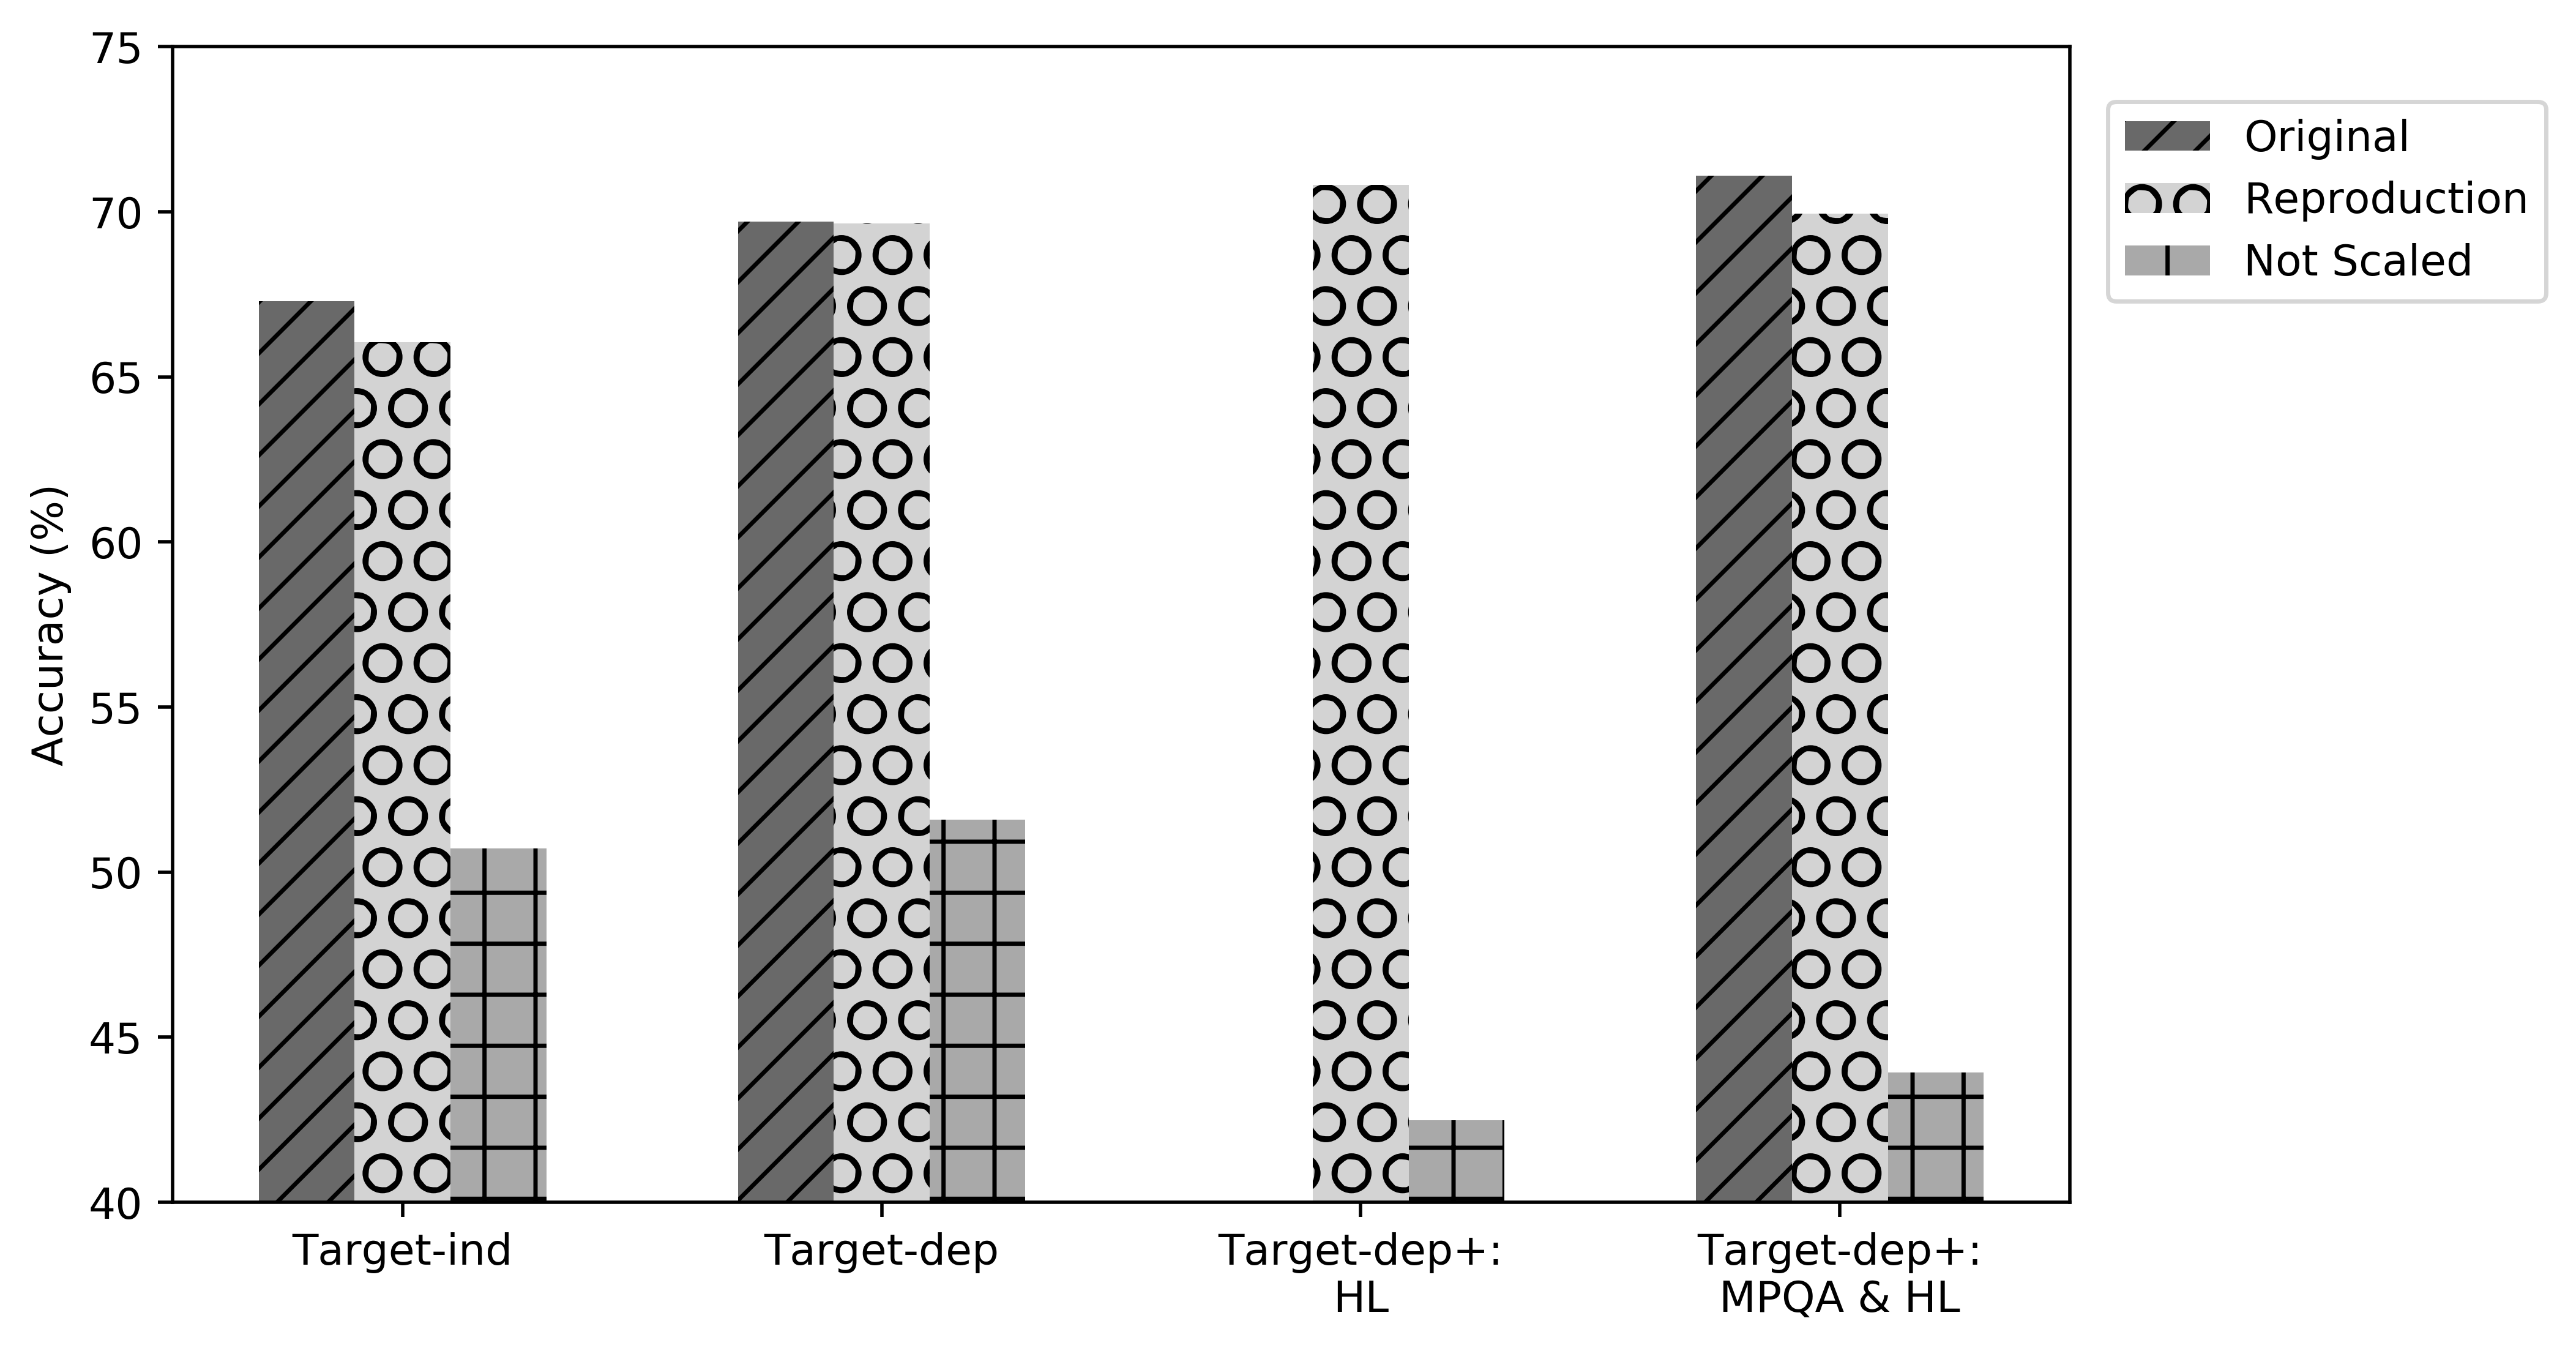

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

index_model = {index : model for index, model in enumerate(models.keys())}
num_models = len(index_model)

# Plotting the Dong Twitter results
scaled_values = {result[1] : result[2] * 100 for result in all_results if result[0] == 'Scaled'}
ordered_scaled_values = [scaled_values[index_model[index]] for index in range(num_models)]
original_values = {result[1] : result[2] for result in all_results if result[0] == 'Original'}
ordered_original_values = [original_values[index_model[index]] for index in range(num_models)]
ns_values = {result[1] : result[2] * 100 for result in all_results if result[0] == 'Not Scaled'}
ordered_ns_values = [ns_values[index_model[index]] for index in range(num_models)]

ind = np.arange(num_models)
width = 0.2
fig, ax = plt.subplots(dpi=500)
fig.set_size_inches(8,5)
original_bar = ax.bar(ind, ordered_original_values, width, color='dimgray', hatch='//')
scaled_bar = ax.bar(ind + width, ordered_scaled_values, width, color='lightgray', hatch='O')
ns_bar = ax.bar(ind + (2 * width), ordered_ns_values, width, color='darkgray', hatch='+')

ax.set_xticks(ind + width)
ax.set_ylim([40 ,75])
model_names = [index_model[index] for index in range(num_models)]
model_names[2] = 'Target-dep+:\nHL'
model_names[3] = 'Target-dep+:\nMPQA & HL'
ax.set_xticklabels(model_names)
leg = ax.legend((original_bar, scaled_bar, ns_bar), ('Original', 'Reproduction', 'Not Scaled'),
                loc = (1.02,0.78))
ax.set_ylabel('Accuracy (%)')
fig.savefig('Target Dependent Final Results.png', dpi=300, bbox_extra_artists=(leg,), bbox_inches='tight')
fig.show()

As you can see not scaling the data (in this can we used [MinMax](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling) affects the results quite a lot more so for the models that contain more parameters. This was not stated in the paper. They did use a different Support Vector Machine Library [LibLinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) however we actually use this library just using the [Scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). Even though in the [Practical guide to LibLinear](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) it states that you should scale and shows the importance like we have done above but this is not stated or reiterated in the paper.

This scaling effect can also be seen in the TDParse models of which that notebook can be found [here](./target_model.ipynb)

In [23]:
best_params = target_dep_plus.get_params(word_vector=[w2v, sswe], senti_lexicon=hu_liu,
                                         random_state=42, lower=False)
target_dep_plus.fit(train_data, train_y, params=best_params)

In [41]:
target_dep_plus_res = target_dep_plus.predict(test_data)
norm_score = lambda score: round(score * 100, 1)
score_not_lower_acc = norm_score(accuracy_score(test_y, target_dep_plus_res))
score_not_lower_f1 = norm_score(f1_score(test_y, target_dep_plus_res, average='macro'))
score_lower_acc = final_results_df['Our results (Acc)']['Target-Dep+ (Hu Liu)']
score_lower_f1 = final_results_df['Our results (Macro F1)']['Target-Dep+ (Hu Liu)']
index = ['Not lower cased (Acc)', 'Lower cased (Acc)', 'Paper results (Acc)', 
         'Not lower cased (Macro F1)', 'Lower cased (Macro F1)', 'Paper results (Macro F1)']
pd.DataFrame({'Target-Dep+' : [score_not_lower_acc, score_lower_acc, 71.1, 
                               score_not_lower_f1, score_lower_f1, 69.9]}, index=index)

,Target-Dep+
Not lower cased (Acc),68.5
Lower cased (Acc),70.8
Paper results (Acc),71.1
Not lower cased (Macro F1),65.0
Lower cased (Macro F1),68.7
Paper results (Macro F1),69.9


As you can see above the results change slightly (~{{str(score_lower_acc - score_not_lower_acc)}}%). This is because the word embeddings used have all been pre-processed and lowered thus causing this affect. Lower casing words in Sentiment Analysis loses some information, as you would expect `GREAT` to be more positive than `great` when lower casing all the words you lose this information. This process is normally done to remove sparsity.